This notebook is part of the Kaggle Home Credit Default Risk competition. The goal of this competition is to predict the probability of default on a loan for a Home Credit Bank client. The evaluation metric is ROC-AUC. In this first notebook we focus on understanding the data landscape through Exploratory Data Analysis (EDA) and constructing a robust preprocessing pipeline to clean, merge, and prepare all data sources for modeling.

# **Base imports**

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import __version__ as sklearn_version
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
print(f'pandas=={pd.__version__}')
print(f'numpy=={np.__version__}')
print(f'sklearn=={sklearn_version}')
print(f'matplotlib=={matplotlib.__version__}')
print(f'seaborn=={sns.__version__}')

pandas==2.2.2
numpy==2.0.2
sklearn==1.6.1
matplotlib==3.10.0
seaborn==0.13.2


# **Loading the data**

In [ ]:
application_train = pd.read_csv('raw-data/application_train.csv')
application_test = pd.read_csv('raw-data/application_test.csv')
bureau = pd.read_csv('raw-data/bureau.csv')
previous_application = pd.read_csv('raw-data/previous_application.csv')
inst = pd.read_csv('raw-data/installments_payments.csv')

# **Preparing Application train/test**

We first check the shape of the train and test datasets to understand the number of observations and features.

In [ ]:
print("application_train -  rows:",application_train.shape[0]," columns:", application_train.shape[1])
print("application_test -  rows:",application_test.shape[0]," columns:", application_test.shape[1])

application_train -  rows: 307511  columns: 122
application_test -  rows: 48744  columns: 121


In [ ]:
for df in [application_train, application_test]:
  df.columns = df.columns.str.lower().str.replace(' ','_')

In [ ]:
y_train = application_train['target']
del application_train['target']
y_train.dtype

dtype('int64')

Next, we verify that column names and data types match between train and test sets to ensure compatibility for modeling.

In [ ]:
print("Columns match exactly:", list(application_train.columns) == list(application_test.columns))

Columns match exactly: True


In [ ]:
train_dtypes = dict(application_train.dtypes)
test_dtypes = dict(application_test.dtypes)

print("Dtypes match by column:", train_dtypes == test_dtypes)

Dtypes match by column: True


We identify categorical and numerical columns to handle them appropriately in preprocessing.

In [ ]:
categorical_col = list(application_train.dtypes[application_train.dtypes == 'object'].index)

In [ ]:
numerical_col = list(application_train.dtypes[application_train.dtypes != 'object'].index)

In [ ]:
for col in categorical_col:
  application_train[col] = application_train[col].str.lower().str.replace(' ','_')
  application_test[col] = application_test[col].str.lower().str.replace(' ','_')

We check for duplicate rows in both train and test sets to avoid biased results.

In [ ]:
print("Any duplicates?", application_train.duplicated().any())
print("Number of duplicates:", application_train.duplicated().sum())

Any duplicates? False
Number of duplicates: 0


In [ ]:
print("Any duplicates?", application_test.duplicated().any())
print("Number of duplicates:", application_test.duplicated().sum())

Any duplicates? False
Number of duplicates: 0


We correct anomalous values in days_employed where 365243 indicates missing work experience, replacing them with zeros.

In [ ]:
application_train['days_employed'].replace(365243, 0, inplace = True)
application_test['days_employed'].replace(365243, 0, inplace = True)

/tmp/ipython-input-2748063229.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_train['days_employed'].replace(365243, 0, inplace = True)
/tmp/ipython-input-2748063229.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

Finally, we save the test dataset IDs separately, as they will be needed for Kaggle submission.

In [ ]:
test_ids = application_test['sk_id_curr'].to_frame()

# **Handling missing values in Application train/test**

First, we check the target variable for missing values. There are no NAs in `y_train`.

In [ ]:
y_train.isnull().sum()

np.int64(0)

We define a function missing_data to compute the total number and percentage of missing values for each feature. This helps us identify columns that need attention.

In [ ]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).sort_values('Total', ascending = False)

We inspect missing values in both train and test datasets.
Columns with more than 30% missing values (50 features) are dropped, as too many NAs could negatively impact model performance. After dropping these columns, 71 features remain.

In [ ]:
missing_data(application_train)

,Total,Percent
commonarea_avg,214865,69.872297
commonarea_medi,214865,69.872297
commonarea_mode,214865,69.872297
nonlivingapartments_avg,213514,69.432963
nonlivingapartments_medi,213514,69.432963
nonlivingapartments_mode,213514,69.432963
fondkapremont_mode,210295,68.386172
livingapartments_medi,210199,68.354953
livingapartments_avg,210199,68.354953
livingapartments_mode,210199,68.354953


In [ ]:
missing_data(application_test)

,Total,Percent
commonarea_avg,33495,68.716150
commonarea_medi,33495,68.716150
commonarea_mode,33495,68.716150
nonlivingapartments_avg,33347,68.412523
nonlivingapartments_medi,33347,68.412523
nonlivingapartments_mode,33347,68.412523
fondkapremont_mode,32797,67.284179
livingapartments_medi,32780,67.249302
livingapartments_avg,32780,67.249302
livingapartments_mode,32780,67.249302


In [ ]:
columns_to_drop = missing_data(application_train).head(50).index.to_list()

application_train = application_train.drop((columns_to_drop), axis = 1)
application_test = application_test.drop((columns_to_drop), axis = 1)

In [ ]:
categorical_col = list(application_train.dtypes[application_train.dtypes == 'object'].index)

In [ ]:
numerical_col = list(application_train.dtypes[application_train.dtypes != 'object'].index)
numerical_col.remove('sk_id_curr')

In [ ]:
application_train.shape, application_test.shape

((307511, 71), (48744, 71))

For columns with fewer than 30% missing values, we fill missing entries using sensible strategies:

- Numerical features are filled with the median to reduce the influence of outliers.

 - Categorical features are filled with the mode to preserve the most common category.

Finally, we verify that the remaining missing values have been handled in both train and test datasets.

In [ ]:
missing_data(application_train)

,Total,Percent
ext_source_3,60965,19.825307
amt_req_credit_bureau_day,41519,13.501631
amt_req_credit_bureau_qrt,41519,13.501631
amt_req_credit_bureau_mon,41519,13.501631
amt_req_credit_bureau_week,41519,13.501631
amt_req_credit_bureau_hour,41519,13.501631
amt_req_credit_bureau_year,41519,13.501631
name_type_suite,1292,0.420148
obs_30_cnt_social_circle,1021,0.332021
obs_60_cnt_social_circle,1021,0.332021


In [ ]:
for col in ['ext_source_3',
 'amt_req_credit_bureau_week',
 'amt_req_credit_bureau_year',
 'amt_req_credit_bureau_qrt',
 'amt_req_credit_bureau_hour',
 'amt_req_credit_bureau_mon',
 'amt_req_credit_bureau_day',
 'def_30_cnt_social_circle',
 'obs_30_cnt_social_circle',
 'def_60_cnt_social_circle',
 'obs_60_cnt_social_circle',
 'ext_source_2',
 'amt_goods_price',
 'amt_annuity',
 'cnt_fam_members',
 'days_last_phone_change']:

 application_train[col] = application_train[col].fillna(application_train[col].median())
 application_test[col] = application_test[col].fillna(application_train[col].median())


application_train['name_type_suite'] = application_train['name_type_suite'].fillna(application_train['name_type_suite'].mode()[0])
application_test['name_type_suite'] = application_test['name_type_suite'].fillna(application_train['name_type_suite'].mode()[0])

In [ ]:
missing_data(application_train).head()

,Total,Percent
sk_id_curr,0,0.0
name_contract_type,0,0.0
code_gender,0,0.0
flag_own_car,0,0.0
flag_own_realty,0,0.0


In [ ]:
missing_data(application_test).head()

,Total,Percent
sk_id_curr,0,0.0
name_contract_type,0,0.0
code_gender,0,0.0
flag_own_car,0,0.0
flag_own_realty,0,0.0


# **Analyzing target and features in Application train/test**

We begin by examining the target variable `y_train`. There is a high class imbalance: approximately 92% of applications are labeled 0 (no default) and 8% are labeled 1 (default). This will influence model choice and evaluation metrics.

In [ ]:
y_train.value_counts(normalize=True)

,proportion
target,
0,0.919271
1,0.080729


Next, we analyze numerical features. For each, we compute the mean, standard deviation, and number/percentage of missing values in both train and test sets. This helps ensure that distributions are similar across datasets, which is important for model generalization.

In [ ]:
results = []

for col in numerical_col:
    train_null_count = application_train[col].isnull().sum()
    test_null_count = application_test[col].isnull().sum()
    train_null_pct = (train_null_count / len(application_train)) * 100
    test_null_pct = (test_null_count / len(application_test)) * 100

    results.append({
        'feature': col,
        'train_mean': round(application_train[col].mean(), 2),
        'train_std': round(application_train[col].std(), 2),
        'train_null': f"{train_null_count} ({train_null_pct:.1f}%)",
        'test_mean': round(application_test[col].mean(), 2),
        'test_std': round(application_test[col].std(), 2),
        'test_null': f"{test_null_count} ({test_null_pct:.1f}%)"
    })

stats_df = pd.DataFrame(results)
print(f"Numerical Features Summary ({len(numerical_col)} features)")
display(stats_df)

Numerical Features Summary (59 features)


,feature,train_mean,train_std,train_null,test_mean,test_std,test_null
0,cnt_children,0.42,0.72,0 (0.0%),0.40,0.71,0 (0.0%)
1,amt_income_total,168797.92,237123.15,0 (0.0%),178431.81,101522.59,0 (0.0%)
2,amt_credit,599026.00,402490.78,0 (0.0%),516740.44,365397.00,0 (0.0%)
3,amt_annuity,27108.49,14493.46,0 (0.0%),29424.01,16012.74,0 (0.0%)
4,amt_goods_price,538316.29,369288.98,0 (0.0%),462618.84,336710.22,0 (0.0%)
5,region_population_relative,0.02,0.01,0 (0.0%),0.02,0.01,0 (0.0%)
6,days_birth,-16037.00,4363.99,0 (0.0%),-16068.08,4325.90,0 (0.0%)
7,days_employed,-1954.85,2307.07,0 (0.0%),-2005.52,2293.10,0 (0.0%)
8,days_registration,-4986.12,3522.89,0 (0.0%),-4967.65,3552.61,0 (0.0%)
9,days_id_publish,-2994.20,1509.45,0 (0.0%),-3051.71,1569.28,0 (0.0%)


We also analyze categorical features by reporting the number of unique categories, the top 3 most frequent values, and the number of missing values in train and test sets.

In [ ]:
cat_results = []

for col in categorical_col:
    train_vals = application_train[col].value_counts().head(3)
    test_vals = application_test[col].value_counts().head(3)

    cat_results.append({
        'feature': col,
        'nunique_train': application_train[col].nunique(),
        'nunique_test': application_test[col].nunique(),
        'top_3_train': [f"{k}({v})" for k, v in train_vals.items()],
        'top_3_test': [f"{k}({v})" for k, v in test_vals.items()],
        'null_train': application_train[col].isnull().sum(),
        'null_test': application_test[col].isnull().sum(),
    })

cat_stats_df = pd.DataFrame(cat_results)

print(f"Categorical Features Summary ({len(categorical_col)} features)")
display(cat_stats_df)

Categorical Features Summary (11 features)


,feature,nunique_train,nunique_test,top_3_train,top_3_test,null_train,null_test
0,name_contract_type,2,2,"[cash_loans(278232), revolving_loans(29279)]","[cash_loans(48305), revolving_loans(439)]",0,0
1,code_gender,3,2,"[f(202448), m(105059), xna(4)]","[f(32678), m(16066)]",0,0
2,flag_own_car,2,2,"[n(202924), y(104587)]","[n(32311), y(16433)]",0,0
3,flag_own_realty,2,2,"[y(213312), n(94199)]","[y(33658), n(15086)]",0,0
4,name_type_suite,7,7,"[unaccompanied(249818), family(40149), spouse,...","[unaccompanied(40638), family(5881), spouse,_p...",0,0
5,name_income_type,8,7,"[working(158774), commercial_associate(71617),...","[working(24533), commercial_associate(11402), ...",0,0
6,name_education_type,5,5,"[secondary_/_secondary_special(218391), higher...","[secondary_/_secondary_special(33988), higher_...",0,0
7,name_family_status,6,5,"[married(196432), single_/_not_married(45444),...","[married(32283), single_/_not_married(7036), c...",0,0
8,name_housing_type,6,6,"[house_/_apartment(272868), with_parents(14840...","[house_/_apartment(43645), with_parents(2234),...",0,0
9,weekday_appr_process_start,7,7,"[tuesday(53901), wednesday(51934), monday(50714)]","[tuesday(9751), wednesday(8457), thursday(8418)]",0,0


Overall, numerical and categorical features show very similar distributions between train and test datasets, confirming that the data is consistent and ready for modeling.

# **Feature engneering for Application train/test**

We create new features to capture relationships between existing variables, which may improve model performance:

- `days_employed_coef` – ratio of days employed to age (days_birth), reflecting relative work experience.

- `income_credit_coef` – ratio of total income to credit amount, representing debt burden.

- `income_per_person` – household income divided by family size, showing per capita income.

- `annnuity_income_ratio` – ratio of annuity payments to income, indicating repayment pressure.

- `payment_rate` – ratio of annuity to credit amount, another measure of repayment intensity.

These features are added to both train and test datasets, and their statistics (mean, std, missing values) are checked to ensure consistency.

In [ ]:
application_train['days_employed_coef'] = application_train['days_employed'] / application_train['days_birth']
application_train['income_credit_coef'] = application_train['amt_income_total'] / application_train['amt_credit']
application_train['income_per_person'] = application_train['amt_income_total'] / application_train['cnt_fam_members']
application_train['annnuity_income_ratio'] = application_train['amt_annuity'] / application_train['amt_income_total']
application_train['payment_rate'] = application_train['amt_annuity'] / application_train['amt_credit']

application_test['days_employed_coef'] = application_test['days_employed'] / application_test['days_birth']
application_test['income_credit_coef'] = application_test['amt_income_total'] / application_test['amt_credit']
application_test['income_per_person'] = application_test['amt_income_total'] / application_test['cnt_fam_members']
application_test['annnuity_income_ratio'] = application_test['amt_annuity'] / application_test['amt_income_total']
application_test['payment_rate'] = application_test['amt_annuity'] / application_test['amt_credit']

In [ ]:
new_cols = ['days_employed_coef', 'income_credit_coef', 'income_per_person', 'annnuity_income_ratio', 'payment_rate']

numerical_col = numerical_col + new_cols

In [ ]:
results = []

for col in new_cols:
    train_null_count = application_train[col].isnull().sum()
    test_null_count = application_test[col].isnull().sum()
    train_null_pct = (train_null_count / len(application_train)) * 100
    test_null_pct = (test_null_count / len(application_test)) * 100

    results.append({
        'feature': col,
        'train_mean': round(application_train[col].mean(), 2),
        'train_std': round(application_train[col].std(), 2),
        'train_null': f"{train_null_count} ({train_null_pct:.1f}%)",
        'test_mean': round(application_test[col].mean(), 2),
        'test_std': round(application_test[col].std(), 2),
        'test_null': f"{test_null_count} ({test_null_pct:.1f}%)"
    })

stats_df = pd.DataFrame(results)
print(f"Numerical Features Summary ({len(numerical_col)} features)")
display(stats_df)

Numerical Features Summary (64 features)


,feature,train_mean,train_std,train_null,test_mean,test_std,test_null
0,days_employed_coef,0.13,0.14,0 (0.0%),0.13,0.14,0 (0.0%)
1,income_credit_coef,0.40,0.51,0 (0.0%),0.49,0.41,0 (0.0%)
2,income_per_person,93106.34,101373.31,0 (0.0%),98078.81,74056.67,0 (0.0%)
3,annnuity_income_ratio,0.18,0.09,0 (0.0%),0.18,0.10,0 (0.0%)
4,payment_rate,0.05,0.02,0 (0.0%),0.07,0.02,0 (0.0%)


In [ ]:
application_train = pd.concat([application_train, y_train], axis=1)

# **Analyzing the Bureau dataset**

The Bureau dataset contains 1,716,428 records describing clients’ previous credits from external financial institutions. Every row corresponds to a single historical credit for a client from our main application dataset (`sk_id_curr`). Since each client can have multiple past credits, the dataset is naturally one-to-many and requires careful cleaning and aggregation before merging into the main training data.

The dataset includes time-indexed variables (e.g., `days_credit`, `days_credit_enddate`) where negative values indicate days in the past relative to the client’s application.

In [ ]:
bureau.shape

(1716428, 17)

In [ ]:
bureau.columns = bureau.columns.str.lower().str.replace(' ','_')

In [ ]:
bureau.dtypes

,0
sk_id_curr,int64
sk_id_bureau,int64
credit_active,object
credit_currency,object
days_credit,int64
credit_day_overdue,int64
days_credit_enddate,float64
days_enddate_fact,float64
amt_credit_max_overdue,float64
cnt_credit_prolong,int64


In [ ]:
bureau_categorical_col = bureau.dtypes[bureau.dtypes == 'object'].index

for col in bureau_categorical_col:
  bureau[col] = bureau[col].str.lower().str.replace(' ','_')

In [ ]:
print("Any duplicates?", bureau.duplicated().any())
print("Number of duplicates:", bureau.duplicated().sum())

Any duplicates? False
Number of duplicates: 0


Missing values are handled carefully:

- Columns with >70% missing values (`amt_annuity`) are dropped.

- For some numerical columns (`amt_credit_max_overdue`, `amt_credit_sum_limit`, `amt_credit_sum_debt`), missing values are filled with 0, reflecting no activity, since missingness logically implies no overdue amounts or debt obligations.

- `days_credit_enddate` is filled using `days_enddate_fact` where possible, and remaining NAs for active credits are filled with the median of active credits.

- Observations missing `amt_credit_sum` are dropped.

After cleaning, the dataset has no missing values.

In [ ]:
missing_data(bureau)

,Total,Percent
amt_annuity,1226791,71.473490
amt_credit_max_overdue,1124488,65.513264
days_enddate_fact,633653,36.916958
amt_credit_sum_limit,591780,34.477415
amt_credit_sum_debt,257669,15.011932
days_credit_enddate,105553,6.149573
amt_credit_sum,13,0.000757
sk_id_curr,0,0.000000
sk_id_bureau,0,0.000000
credit_day_overdue,0,0.000000


In [ ]:
bureau = bureau.drop('amt_annuity', axis = 1)

bureau['amt_credit_max_overdue'] = bureau['amt_credit_max_overdue'].fillna(0)
bureau['amt_credit_sum_limit'] = bureau['amt_credit_sum_limit'].fillna(0)
bureau['amt_credit_sum_debt'] = bureau['amt_credit_sum_debt'].fillna(0)

In [ ]:
missing_data(bureau)

,Total,Percent
days_enddate_fact,633653,36.916958
days_credit_enddate,105553,6.149573
amt_credit_sum,13,0.000757
sk_id_curr,0,0.000000
credit_currency,0,0.000000
credit_active,0,0.000000
credit_day_overdue,0,0.000000
sk_id_bureau,0,0.000000
days_credit,0,0.000000
amt_credit_max_overdue,0,0.000000


In [ ]:
# Using 'days_enddate_fact' to fill NAs in 'days_credit_enddate'

# Creating a mask for the condition
mask = (pd.isna(bureau.days_credit_enddate)) & (pd.notna(bureau.days_enddate_fact))

# Filling the values where the condition is True
bureau.loc[mask, 'days_credit_enddate'] = bureau.loc[mask, 'days_enddate_fact']

# 'days_enddate_fact' is no longer needed since it has too many NAs itself ( > 30% NAs)

bureau = bureau.drop('days_enddate_fact', axis = 1)

In [ ]:
missing_data(bureau)

,Total,Percent
days_credit_enddate,72764,4.239269
amt_credit_sum,13,0.000757
sk_id_bureau,0,0.000000
credit_active,0,0.000000
credit_currency,0,0.000000
days_credit,0,0.000000
sk_id_curr,0,0.000000
credit_day_overdue,0,0.000000
amt_credit_max_overdue,0,0.000000
cnt_credit_prolong,0,0.000000


In [ ]:
# Dropping 13 observations where amt_credit_sum is unknown

bureau = bureau.dropna(subset=['amt_credit_sum'])

In [ ]:
missing_data(bureau).head()

,Total,Percent
days_credit_enddate,72760,4.239068
sk_id_bureau,0,0.000000
sk_id_curr,0,0.000000
credit_active,0,0.000000
credit_currency,0,0.000000


In [ ]:
# There are still 72 760 observations with missing 'days_credit_enddate' values, those are all active credits, we will fill those NAs with the median value from active credits

bureau[pd.isna(bureau.days_credit_enddate) & (bureau.credit_active == 'active')].head()

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update
3,215354,5714465,active,currency_1,-203,0,NaN,0.0,0,90000.0,0.0,0.00,0.0,credit_card,-16
17,238881,5714486,active,currency_1,-381,0,NaN,0.0,0,450000.0,520920.0,0.00,0.0,consumer_credit,-4
20,238881,5714489,active,currency_1,-392,0,NaN,0.0,0,252000.0,23679.0,228320.10,0.0,credit_card,-22
43,435112,5714518,active,currency_1,-1483,0,NaN,0.0,0,200250.0,0.0,0.00,0.0,credit_card,-848
75,303740,5714554,active,currency_1,-581,0,NaN,0.0,0,384750.0,263056.5,121690.17,0.0,credit_card,-22


In [ ]:
active_median = bureau[bureau.credit_active == 'active']['days_credit_enddate'].median()

print(f"Median end date for active credits: {active_median:.0f} days")

bureau['days_credit_enddate'] = bureau['days_credit_enddate'].fillna(active_median)

Median end date for active credits: 678 days


In [ ]:
missing_data(bureau).head()

,Total,Percent
sk_id_curr,0,0.0
sk_id_bureau,0,0.0
credit_active,0,0.0
credit_currency,0,0.0
days_credit,0,0.0


**Key insights from EDA of the cleaned dataset:**

Credit status distribution:

- Most of the credits are in the status Closed (~900K). On the second place are the Active credits ( a bit under 600K). Sold and Bad debt are just a few

Currency:

- Almost all credits are denominated in currency_1

- Other currencies represent a small fraction

Duration and timeline:

- `days_credit` shows that recent credit inquiries dominate the dataset

- 75% of records have days_credit_update within the last 30 days, indicating the dataset is operationally up-to-date

Overdue characteristics:

- Overdue amounts and overdue days are zero for the majority of clients

- A minority of credits show significant overdue behavior, which is expected to be highly predictive

Credit types:

- ~73% are consumer credits

- ~23% are credit cards

- Remaining categories include mortgages, car loans, and microloans

In [ ]:
bureau.groupby('credit_active').size().sort_values(ascending=False)

,0
credit_active,
closed,1079268
active,630599
sold,6527
bad_debt,21


In [ ]:
bureau.groupby('credit_currency').size()

,0
credit_currency,
currency_1,1715007
currency_2,1224
currency_3,174
currency_4,10


<Axes: >

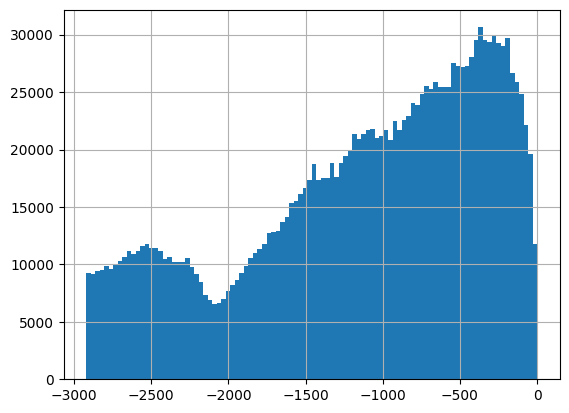

In [ ]:
bureau.days_credit.hist(bins = 100)

In [ ]:
bureau.credit_day_overdue.describe().round(2)

,credit_day_overdue
count,1716415.00
mean,0.82
std,36.54
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,2792.00


In [ ]:
bureau.amt_credit_max_overdue.describe().round()

,amt_credit_max_overdue
count,1716415.0
mean,1319.0
std,121007.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,115987185.0


<Axes: >

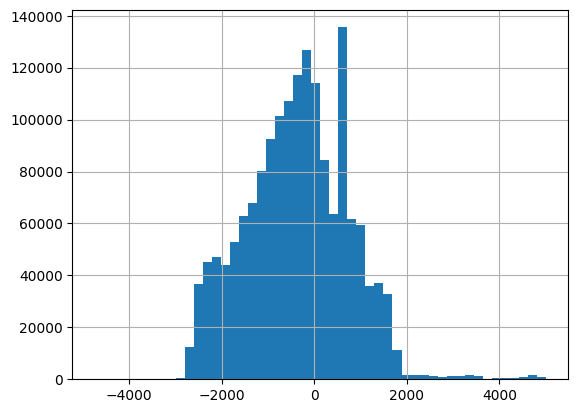

In [ ]:
bureau[bureau.days_credit_enddate.between(-5000, 5000)]['days_credit_enddate'].hist(bins=50)

In [ ]:
bureau.cnt_credit_prolong.describe().round(3)

,cnt_credit_prolong
count,1716415.000
mean,0.006
std,0.096
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,9.000


In [ ]:
bureau.amt_credit_sum.describe().round()

,amt_credit_sum
count,1716415.0
mean,354995.0
std,1149811.0
min,0.0
25%,51300.0
50%,125518.0
75%,315000.0
max,585000000.0


In [ ]:
bureau.amt_credit_sum.quantile(0.95)

np.float64(1350000.0)

<Axes: >

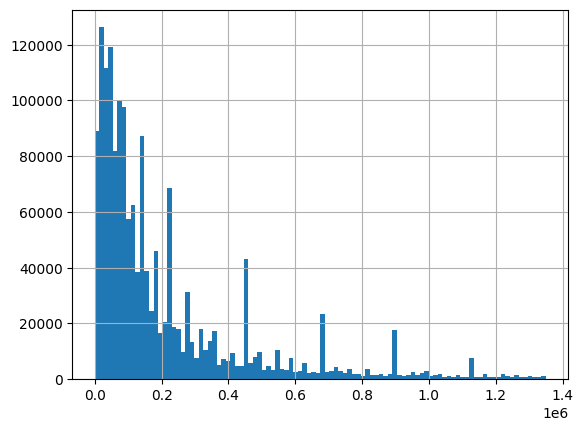

In [ ]:
bureau[bureau.amt_credit_sum < 1350000]['amt_credit_sum'].hist(bins = 100)

In [ ]:
bureau.amt_credit_sum_debt.describe().round()

,amt_credit_sum_debt
count,1716415.0
mean,116504.0
std,626405.0
min,-4705600.0
25%,0.0
50%,0.0
75%,1971.0
max,170100000.0


In [ ]:
bureau.amt_credit_sum_limit.describe().round()

,amt_credit_sum_limit
count,1716415.0
mean,4082.0
std,36572.0
min,-586406.0
25%,0.0
50%,0.0
75%,0.0
max,4705600.0


In [ ]:
bureau.amt_credit_sum_overdue.describe().round()

,amt_credit_sum_overdue
count,1716415.0
mean,38.0
std,5938.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,3756681.0


In [ ]:
bureau['credit_type'].value_counts(normalize=True).round(6) * 100

,proportion
credit_type,
consumer_credit,72.9201
credit_card,23.4323
car_loan,1.6132
mortgage,1.0715
microloan,0.7232
loan_for_business_development,0.1151
another_type_of_loan,0.0587
unknown_type_of_loan,0.0323
loan_for_working_capital_replenishment,0.0273


In [ ]:
bureau.days_credit_update.describe().round()

,days_credit_update
count,1716415.0
mean,-594.0
std,721.0
min,-41947.0
25%,-908.0
50%,-395.0
75%,-33.0
max,372.0


Since each client can have dozens of past credits, we build client-level aggregated features. We separate credits into:

- Active credits

- Closed credits

This separation is important because active and closed credits behave differently and contribute different types of information about credit risk.

For each group, we compute:

- Mean

- Maximum

- Minimum

- Sum

- Count

Features include:

- `days_credit`

- `days_credit_enddate`

- `credit_day_overdue`

- `amt_credit_sum`

- `amt_credit_sum_debt` anf others

In [ ]:
num_aggregations = {
    'days_credit': ['min', 'max', 'mean'],
    'days_credit_enddate': ['min', 'max', 'mean'],
    'days_credit_update': ['mean'],
    'credit_day_overdue': ['max', 'mean'],
    'amt_credit_max_overdue': ['mean'],
    'amt_credit_sum': ['max', 'mean', 'sum'],
    'amt_credit_sum_debt': ['max', 'mean', 'sum'],
    'amt_credit_sum_overdue': ['mean'],
    'amt_credit_sum_limit': ['mean', 'sum'],
    'cnt_credit_prolong': ['sum']
}

In [ ]:
# Filtering for Active credits
active_credits = bureau[bureau['credit_active'] == 'active']

# Filtering for Closed credits
closed_credits = bureau[bureau['credit_active'] == 'closed']

print(f"Active credits: {len(active_credits)}")
print(f"Closed credits: {len(closed_credits)}")

Active credits: 630599
Closed credits: 1079268


In [ ]:
# Aggregations For active credits
active_agg = active_credits.groupby('sk_id_curr').agg(num_aggregations)

# Aggregations For closed credits
closed_agg = closed_credits.groupby('sk_id_curr').agg(num_aggregations)

print(f"Active features shape: {active_agg.shape}")
print(f"Closed features shape: {closed_agg.shape}")

Active features shape: (251812, 20)
Closed features shape: (267925, 20)


In [ ]:
active_agg.head()

days_credit                  days_credit_enddate          \
                   min  max        mean                 min     max   
sk_id_curr                                                            
100001            -559  -49 -309.333333               411.0  1778.0   
100002           -1042 -103 -572.500000               678.0   780.0   
100003            -606 -606 -606.000000              1216.0  1216.0   
100005            -137  -62  -99.500000               122.0  1324.0   
100008             -78  -78  -78.000000               471.0   471.0   

                        days_credit_update credit_day_overdue       \
                   mean               mean                max mean   
sk_id_curr                                                           
100001      1030.333333         -10.666667                  0  0.0   
100002       729.000000         -15.500000                  0  0.0   
100003      1216.000000         -43.000000                  0  0.0   
100005       723.000000         -21.000000                  0  0.0   
100008       471.000000         -16.000000                  0  0.0   

           amt_credit_max_overdue amt_credit_sum                           \
                             mean            max         mean         sum   
sk_id_curr                                                                  
100001                       0.00       378000.0  294675.0000  884025.000   
100002                      20.25       450000.0  240994.2825  481988.565   
100003                       0.00       810000.0  810000.0000  810000.000   
100005                       0.00       568800.0  299313.0000  598626.000   
100008                       0.00       267606.0  267606.0000  267606.000   

           amt_credit_sum_debt                      amt_credit_sum_overdue  \
                           max       mean       sum                   mean   
sk_id_curr                                                                   
100001                373239.0  198895.50  596686.5                    0.0   
100002                245781.0  122890.50  245781.0                    0.0   
100003                     0.0       0.00       0.0                    0.0   
100005                543087.0  284204.25  568408.5                    0.0   
100008                240057.0  240057.00  240057.0                    0.0   

           amt_credit_sum_limit             cnt_credit_prolong  
                           mean         sum                sum  
sk_id_curr                                                      
100001                   0.0000       0.000                  0  
100002               15994.2825   31988.565                  0  
100003              810000.0000  810000.000                  0  
100005                   0.0000       0.000                  0  
100008                   0.0000       0.000                  0

In [ ]:
closed_agg.head()

days_credit                   days_credit_enddate         \
                   min  max         mean                 min    max   
sk_id_curr                                                            
100001           -1572 -857 -1054.250000             -1329.0 -179.0   
100002           -1437 -476  -974.500000             -1072.0   85.0   
100003           -2586 -775 -1665.666667             -2434.0 -420.0   
100004           -1326 -408  -867.000000              -595.0 -382.0   
100005            -373 -373  -373.000000              -128.0 -128.0   

                        days_credit_update credit_day_overdue       \
                   mean               mean                max mean   
sk_id_curr                                                           
100001      -628.500000        -155.000000                  0  0.0   
100002      -487.000000        -661.333333                  0  0.0   
100003     -1131.333333       -1073.666667                  0  0.0   
100004      -488.500000        -532.000000                  0  0.0   
100005      -128.000000        -121.000000                  0  0.0   

           amt_credit_max_overdue amt_credit_sum                      \
                             mean            max      mean       sum   
sk_id_curr                                                             
100001                     0.0000       279720.0  142335.0  569340.0   
100002                  1394.1075       135000.0   63844.5  383067.0   
100003                     0.0000       112500.0   69133.5  207400.5   
100004                     0.0000        94537.8   94518.9  189037.8   
100005                     0.0000        58500.0   58500.0   58500.0   

           amt_credit_sum_debt           amt_credit_sum_overdue  \
                           max mean  sum                   mean   
sk_id_curr                                                        
100001                     0.0  0.0  0.0                    0.0   
100002                     0.0  0.0  0.0                    0.0   
100003                     0.0  0.0  0.0                    0.0   
100004                     0.0  0.0  0.0                    0.0   
100005                     0.0  0.0  0.0                    0.0   

           amt_credit_sum_limit      cnt_credit_prolong  
                           mean  sum                sum  
sk_id_curr                                               
100001                      0.0  0.0                  0  
100002                      0.0  0.0                  0  
100003                      0.0  0.0                  0  
100004                      0.0  0.0                  0  
100005                      0.0  0.0                  0

In [ ]:
# Renaming the columns

active_agg.columns = ['active_' + '_'.join(col) for col in active_agg.columns]

closed_agg.columns = ['closed_' + '_'.join(col) for col in closed_agg.columns]

print("Active columns sample:", list(active_agg.columns)[:5])
print("Closed columns sample:", list(closed_agg.columns)[:5])

Active columns sample: ['active_days_credit_min', 'active_days_credit_max', 'active_days_credit_mean', 'active_days_credit_enddate_min', 'active_days_credit_enddate_max']
Closed columns sample: ['closed_days_credit_min', 'closed_days_credit_max', 'closed_days_credit_mean', 'closed_days_credit_enddate_min', 'closed_days_credit_enddate_max']


In [ ]:
active_agg.head()

,active_days_credit_min,active_days_credit_max,active_days_credit_mean,active_days_credit_enddate_min,active_days_credit_enddate_max,active_days_credit_enddate_mean,active_days_credit_update_mean,active_credit_day_overdue_max,active_credit_day_overdue_mean,active_amt_credit_max_overdue_mean,active_amt_credit_sum_max,active_amt_credit_sum_mean,active_amt_credit_sum_sum,active_amt_credit_sum_debt_max,active_amt_credit_sum_debt_mean,active_amt_credit_sum_debt_sum,active_amt_credit_sum_overdue_mean,active_amt_credit_sum_limit_mean,active_amt_credit_sum_limit_sum,active_cnt_credit_prolong_sum
sk_id_curr,,,,,,,,,,,,,,,,,,,,
100001,-559,-49,-309.333333,411.0,1778.0,1030.333333,-10.666667,0,0.0,0.00,378000.0,294675.0000,884025.000,373239.0,198895.50,596686.5,0.0,0.0000,0.000,0
100002,-1042,-103,-572.500000,678.0,780.0,729.000000,-15.500000,0,0.0,20.25,450000.0,240994.2825,481988.565,245781.0,122890.50,245781.0,0.0,15994.2825,31988.565,0
100003,-606,-606,-606.000000,1216.0,1216.0,1216.000000,-43.000000,0,0.0,0.00,810000.0,810000.0000,810000.000,0.0,0.00,0.0,0.0,810000.0000,810000.000,0
100005,-137,-62,-99.500000,122.0,1324.0,723.000000,-21.000000,0,0.0,0.00,568800.0,299313.0000,598626.000,543087.0,284204.25,568408.5,0.0,0.0000,0.000,0
100008,-78,-78,-78.000000,471.0,471.0,471.000000,-16.000000,0,0.0,0.00,267606.0,267606.0000,267606.000,240057.0,240057.00,240057.0,0.0,0.0000,0.000,0


In [ ]:
closed_agg.head()

,closed_days_credit_min,closed_days_credit_max,closed_days_credit_mean,closed_days_credit_enddate_min,closed_days_credit_enddate_max,closed_days_credit_enddate_mean,closed_days_credit_update_mean,closed_credit_day_overdue_max,closed_credit_day_overdue_mean,closed_amt_credit_max_overdue_mean,closed_amt_credit_sum_max,closed_amt_credit_sum_mean,closed_amt_credit_sum_sum,closed_amt_credit_sum_debt_max,closed_amt_credit_sum_debt_mean,closed_amt_credit_sum_debt_sum,closed_amt_credit_sum_overdue_mean,closed_amt_credit_sum_limit_mean,closed_amt_credit_sum_limit_sum,closed_cnt_credit_prolong_sum
sk_id_curr,,,,,,,,,,,,,,,,,,,,
100001,-1572,-857,-1054.250000,-1329.0,-179.0,-628.500000,-155.000000,0,0.0,0.0000,279720.0,142335.0,569340.0,0.0,0.0,0.0,0.0,0.0,0.0,0
100002,-1437,-476,-974.500000,-1072.0,85.0,-487.000000,-661.333333,0,0.0,1394.1075,135000.0,63844.5,383067.0,0.0,0.0,0.0,0.0,0.0,0.0,0
100003,-2586,-775,-1665.666667,-2434.0,-420.0,-1131.333333,-1073.666667,0,0.0,0.0000,112500.0,69133.5,207400.5,0.0,0.0,0.0,0.0,0.0,0.0,0
100004,-1326,-408,-867.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,0.0000,94537.8,94518.9,189037.8,0.0,0.0,0.0,0.0,0.0,0.0,0
100005,-373,-373,-373.000000,-128.0,-128.0,-128.000000,-121.000000,0,0.0,0.0000,58500.0,58500.0,58500.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Aggregation outcome: every `sk_id_curr` receives a complete vector of aggregated credit features.
Clients with no active or closed credits receive zeros, ensuring consistent dimensionality
The final aggregated dataset is fully synchronized and ready to be merged into the main training dataset

In [ ]:
# Combining active and closed features
bureau_agg = active_agg.join(closed_agg, how='outer')

# Filling any missing values with 0 (if someone has no active/closed credits)
bureau_agg = bureau_agg.fillna(0)

print(f"Final aggregated shape: {bureau_agg.shape}")

Final aggregated shape: (305620, 40)


In [ ]:
bureau_agg.head()

,active_days_credit_min,active_days_credit_max,active_days_credit_mean,active_days_credit_enddate_min,active_days_credit_enddate_max,active_days_credit_enddate_mean,active_days_credit_update_mean,active_credit_day_overdue_max,active_credit_day_overdue_mean,active_amt_credit_max_overdue_mean,active_amt_credit_sum_max,active_amt_credit_sum_mean,active_amt_credit_sum_sum,active_amt_credit_sum_debt_max,active_amt_credit_sum_debt_mean,active_amt_credit_sum_debt_sum,active_amt_credit_sum_overdue_mean,active_amt_credit_sum_limit_mean,active_amt_credit_sum_limit_sum,active_cnt_credit_prolong_sum,closed_days_credit_min,closed_days_credit_max,closed_days_credit_mean,closed_days_credit_enddate_min,closed_days_credit_enddate_max,closed_days_credit_enddate_mean,closed_days_credit_update_mean,closed_credit_day_overdue_max,closed_credit_day_overdue_mean,closed_amt_credit_max_overdue_mean,closed_amt_credit_sum_max,closed_amt_credit_sum_mean,closed_amt_credit_sum_sum,closed_amt_credit_sum_debt_max,closed_amt_credit_sum_debt_mean,closed_amt_credit_sum_debt_sum,closed_amt_credit_sum_overdue_mean,closed_amt_credit_sum_limit_mean,closed_amt_credit_sum_limit_sum,closed_cnt_credit_prolong_sum
sk_id_curr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-559.0,-49.0,-309.333333,411.0,1778.0,1030.333333,-10.666667,0.0,0.0,0.00,378000.0,294675.0000,884025.000,373239.0,198895.50,596686.5,0.0,0.0000,0.000,0.0,-1572.0,-857.0,-1054.250000,-1329.0,-179.0,-628.500000,-155.000000,0.0,0.0,0.0000,279720.0,142335.0,569340.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100002,-1042.0,-103.0,-572.500000,678.0,780.0,729.000000,-15.500000,0.0,0.0,20.25,450000.0,240994.2825,481988.565,245781.0,122890.50,245781.0,0.0,15994.2825,31988.565,0.0,-1437.0,-476.0,-974.500000,-1072.0,85.0,-487.000000,-661.333333,0.0,0.0,1394.1075,135000.0,63844.5,383067.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100003,-606.0,-606.0,-606.000000,1216.0,1216.0,1216.000000,-43.000000,0.0,0.0,0.00,810000.0,810000.0000,810000.000,0.0,0.00,0.0,0.0,810000.0000,810000.000,0.0,-2586.0,-775.0,-1665.666667,-2434.0,-420.0,-1131.333333,-1073.666667,0.0,0.0,0.0000,112500.0,69133.5,207400.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0000,0.000,0.0,0.00,0.0,0.0,0.0000,0.000,0.0,-1326.0,-408.0,-867.000000,-595.0,-382.0,-488.500000,-532.000000,0.0,0.0,0.0000,94537.8,94518.9,189037.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100005,-137.0,-62.0,-99.500000,122.0,1324.0,723.000000,-21.000000,0.0,0.0,0.00,568800.0,299313.0000,598626.000,543087.0,284204.25,568408.5,0.0,0.0000,0.000,0.0,-373.0,-373.0,-373.000000,-128.0,-128.0,-128.000000,-121.000000,0.0,0.0,0.0000,58500.0,58500.0,58500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Analyzing the Previous application dataset**

The previous_application dataset contains detailed information about every credit request a client submitted to Home Credit before their main application. It includes both approved and refused loans and is one of the most important behavioral sources in the competition.

In [ ]:
previous_application.shape

(1670214, 37)

In [ ]:
previous_application.columns = previous_application.columns.str.lower().str.replace(' ','_')

In [ ]:
previous_application.dtypes

,0
sk_id_prev,int64
sk_id_curr,int64
name_contract_type,object
amt_annuity,float64
amt_application,float64
amt_credit,float64
amt_down_payment,float64
amt_goods_price,float64
weekday_appr_process_start,object
hour_appr_process_start,int64


In [ ]:
prev_categorical_col = previous_application.dtypes[previous_application.dtypes == 'object'].index

for col in prev_categorical_col:
  previous_application[col] = previous_application[col].str.lower().str.replace(' ','_')

In [ ]:
print("Any duplicates?", previous_application.duplicated().any())

print("Number of duplicates:", previous_application.duplicated().sum())

Any duplicates? False
Number of duplicates: 0


Several variables clearly do not contribute meaningful predictive value (e.g., exact weekday/hour of processing or technical flags).
We removed:

- `weekday_appr_process_start`

- `hour_appr_process_start`

- `flag_last_appl_per_contract`

- `nflag_last_appl_in_day`

These features are either too granular, operational, or irrelevant for credit risk modeling.

In [ ]:
previous_application = previous_application.drop(['weekday_appr_process_start',
                                                  'hour_appr_process_start',
                                                  'flag_last_appl_per_contract',
                                                  'nflag_last_appl_in_day']
                                                 , axis = 1)

In [ ]:
missing_data(previous_application)

,Total,Percent
rate_interest_privileged,1664263,99.643698
rate_interest_primary,1664263,99.643698
rate_down_payment,895844,53.636480
amt_down_payment,895844,53.636480
name_type_suite,820405,49.119754
days_termination,673065,40.298129
nflag_insured_on_approval,673065,40.298129
days_last_due,673065,40.298129
days_last_due_1st_version,673065,40.298129
days_first_due,673065,40.298129


Using the missing_data() helper, we identified variables with extremely high missingness.

Columns with more than 30% missing values were removed, except those that still hold economic meaning (e.g., `amt_down_payment`, which we kept).

In [ ]:
previous_application = previous_application.drop(['rate_interest_privileged',
                                                  'rate_interest_primary',
                                                  'rate_down_payment',
                                                  'name_type_suite',
                                                  'days_termination',
                                                  'nflag_insured_on_approval',
                                                  'days_last_due',
                                                  'days_last_due_1st_version',
                                                  'days_first_due',
                                                  'days_first_drawing',
                                                  ], axis = 1)

In [ ]:
missing_data(previous_application)

,Total,Percent
amt_down_payment,895844,53.636480
amt_goods_price,385515,23.081773
amt_annuity,372235,22.286665
cnt_payment,372230,22.286366
product_combination,346,0.020716
amt_credit,1,0.000060
name_contract_type,0,0.000000
amt_application,0,0.000000
sk_id_prev,0,0.000000
sk_id_curr,0,0.000000


We applied simple, logical imputation rules:

**Numerical**

- `amt_down_payment`, `amt_goods_price`, `amt_annuity` → filled with 0
(missing values here mean “not applicable” rather than unknown)

- `cnt_payment` → filled with median
(represents number of installments for installment loans)

**Categorical**

- `product_combination` → filled with mode
(most common product combination used as fallback)

We also removed rows with missing `amt_credit`, as the credit amount is essential to any aggregation.

In [ ]:
previous_application['amt_down_payment'] = previous_application['amt_down_payment'].fillna(0)
previous_application['amt_goods_price'] = previous_application['amt_goods_price'].fillna(0)
previous_application['amt_annuity'] = previous_application['amt_annuity'].fillna(0)
previous_application['cnt_payment'] = previous_application['cnt_payment'].fillna(previous_application['cnt_payment'].median())
previous_application['product_combination'] = previous_application['product_combination'].fillna(previous_application['product_combination'].mode()[0])

In [ ]:
previous_application = previous_application[previous_application['amt_credit'].notna()]

In [ ]:
previous_application.shape

(1670213, 23)

In [ ]:
missing_data(previous_application)

,Total,Percent
sk_id_prev,0,0.0
sk_id_curr,0,0.0
name_contract_type,0,0.0
amt_annuity,0,0.0
amt_application,0,0.0
amt_credit,0,0.0
amt_down_payment,0,0.0
amt_goods_price,0,0.0
name_cash_loan_purpose,0,0.0
name_contract_status,0,0.0


For each categorical variable, we plotted frequency distributions to understand the structure of the data.

Key findings:

- Contract types are dominated by cash_loans (~ 747k) and consumer_loans (~ 729k),revolving loans and rare categories form the rest.

- Loan purposes are dominated by 'xap' (~ 922k) and 'xna' (~ 678k) meaning loan purpose is often missing or not recorded.The remaining categories form a long tail of rare purposes.

- Contract status shows outcomes of previous applications: approved (>1M), canceled (~ 316k), refused (~ 291k), unused_offer (~26k). This is an extremely important behavioral signal. These distributions guided later feature engineering (e.g., aggregations separately for approved/refused).

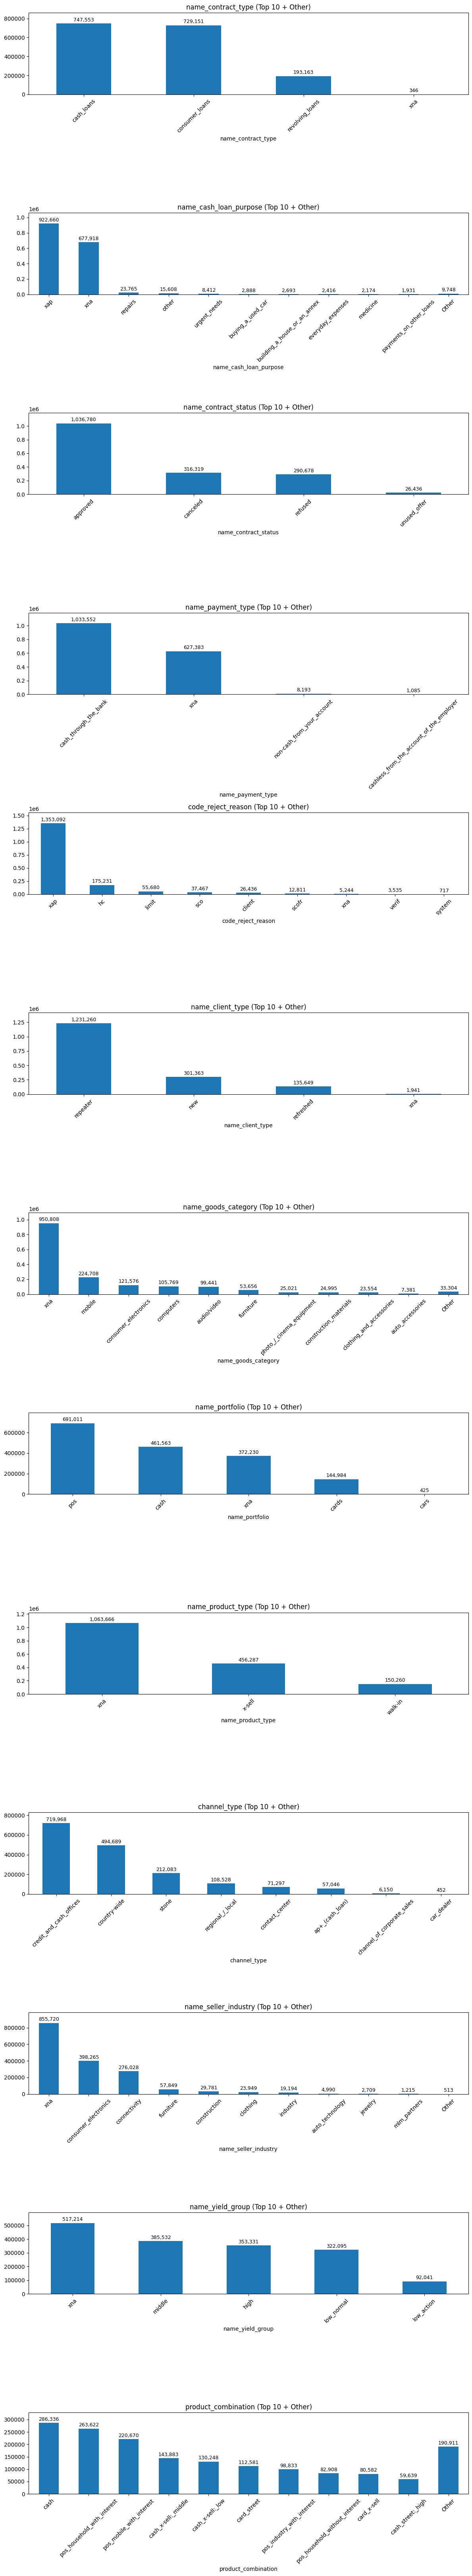

In [ ]:
cat = list(previous_application.dtypes[previous_application.dtypes == 'object'].index)

fig, axes = plt.subplots(len(cat), 1, figsize=(12, 5*len(cat)))

# If only one column, make axes a list
if len(cat) == 1:
    axes = [axes]

for i, col in enumerate(cat):
    value_counts = previous_application[col].value_counts()

    if len(value_counts) > 10:
        top_values = value_counts.head(10)
        other_count = value_counts[10:].sum()
        top_values['Other'] = other_count
    else:
        top_values = value_counts

    bars = top_values.plot(kind='bar', ax=axes[i], title=f'{col} (Top 10 + Other)')
    axes[i].tick_params(axis='x', rotation=45)

    # Add values with adjusted y-position and set y-axis limits
    max_val = top_values.max()
    for idx, value in enumerate(top_values):
        axes[i].text(idx, value + max_val * 0.03, f'{value:,}',
                    ha='center', fontsize=9)

    # Set y-axis limit to accommodate text labels
    axes[i].set_ylim(0, max_val * 1.15)  # 15% extra space for labels

plt.tight_layout()
plt.show()

We printed descriptive statistics for all numerical variables to understand ranges, skewness, and potential inconsistencies.

Findings include:

- monetary fields (amt_application, amt_credit, amt_goods_price) have wide ranges

- time-related features (days_decision) contain both positive and negative values

- cnt_payment shows typical installment-count patterns (12, 24, 36, etc.)

This step mainly served to validate data quality before aggregation.

In [ ]:
num = list(previous_application.dtypes[previous_application.dtypes != 'object'].index)

for col in num:
    print(f"=== {col} ===")
    print(previous_application[col].describe().round(2))
    print('\n' + '-'*50 + '\n')

=== sk_id_prev ===
count    1670213.00
mean     1923088.97
std       532598.07
min      1000001.00
25%      1461857.00
50%      1923110.00
75%      2384280.00
max      2845382.00
Name: sk_id_prev, dtype: float64

--------------------------------------------------

=== sk_id_curr ===
count    1670213.00
mean      278357.08
std       102814.78
min       100001.00
25%       189329.00
50%       278714.00
75%       367514.00
max       456255.00
Name: sk_id_curr, dtype: float64

--------------------------------------------------

=== amt_annuity ===
count    1670213.00
mean       12399.26
std        14625.41
min            0.00
25%         2250.00
50%         8250.25
75%        16824.06
max       418058.14
Name: amt_annuity, dtype: float64

--------------------------------------------------

=== amt_application ===
count    1670213.00
mean      175233.97
std       292779.82
min            0.00
25%        18720.00
50%        71046.00
75%       180360.00
max      6905160.00
Name: amt_applicati

To capture past behavior properly, we separated the dataset into two subsets:

- approved applications

- refused applications

Then we computed aggregated behavioral statistics for each group per client (sk_id_curr):

- `amt_annuity`: min, max, mean

- `amt_application`: min, max, mean

- `amt_credit`: min, max, mean

- `amt_down_payment`: min, max, mean

- `amt_goods_price`: min, max, mean

- `days_decision`: min, max, mean

- `cnt_payment`: mean, sum

These aggregates capture:

- typical loan size a client applies for

- how their requests vary over time

- how many installments they usually take

- whether they over-apply or apply for unusually large loans

- their historical approval/refusal patterns

The final aggregated dataset (prev_application_agg) forms a powerful behavioral block to merge back into the main dataset.

In [ ]:
num_aggregations = {
    'amt_annuity': ['min', 'max', 'mean'],
    'amt_application': ['min', 'max', 'mean'],
    'amt_credit': ['min', 'max', 'mean'],
    'amt_down_payment': ['min', 'max', 'mean'],
    'amt_goods_price': ['min', 'max', 'mean'],
    'days_decision': ['min', 'max', 'mean'],
    'cnt_payment': ['mean', 'sum'],
}

In [ ]:
approved_app = previous_application[previous_application['name_contract_status'] == 'approved']

refused_app = previous_application[previous_application['name_contract_status'] == 'refused']

print(f"approved applications: {len(approved_app)}")
print(f"refused applications: {len(refused_app)}")

approved applications: 1036780
refused applications: 290678


In [ ]:
approved_agg = approved_app.groupby('sk_id_curr').agg(num_aggregations)

refused_agg = refused_app.groupby('sk_id_curr').agg(num_aggregations)

print(f"Active features shape: {approved_agg.shape}")
print(f"Closed features shape: {refused_agg.shape}")

Active features shape: (337698, 20)
Closed features shape: (118277, 20)


In [ ]:
approved_agg.head()

amt_annuity                       amt_application            \
                   min        max       mean             min       max   
sk_id_curr                                                               
100001        3951.000   3951.000   3951.000         24835.5   24835.5   
100002        9251.775   9251.775   9251.775        179055.0  179055.0   
100003        6737.310  98356.995  56553.990         68809.5  900000.0   
100004        5357.250   5357.250   5357.250         24282.0   24282.0   
100005        4813.200   4813.200   4813.200         44617.5   44617.5   

                     amt_credit                      amt_down_payment          \
                mean        min        max      mean              min     max   
sk_id_curr                                                                      
100001       24835.5    23787.0    23787.0   23787.0           2520.0  2520.0   
100002      179055.0   179055.0   179055.0  179055.0              0.0     0.0   
100003      435436.5    68053.5  1035882.0  484191.0              0.0  6885.0   
100004       24282.0    20106.0    20106.0   20106.0           4860.0  4860.0   
100005       44617.5    40153.5    40153.5   40153.5           4464.0  4464.0   

                   amt_goods_price                     days_decision        \
              mean             min       max      mean           min   max   
sk_id_curr                                                                   
100001      2520.0         24835.5   24835.5   24835.5         -1740 -1740   
100002         0.0        179055.0  179055.0  179055.0          -606  -606   
100003      2295.0         68809.5  900000.0  435436.5         -2341  -746   
100004      4860.0         24282.0   24282.0   24282.0          -815  -815   
100005      4464.0         44617.5   44617.5   44617.5          -757  -757   

                   cnt_payment        
              mean        mean   sum  
sk_id_curr                            
100001     -1740.0         8.0   8.0  
100002      -606.0        24.0  24.0  
100003     -1305.0        10.0  30.0  
100004      -815.0         4.0   4.0  
100005      -757.0        12.0  12.0

In [ ]:
refused_agg.head()

amt_annuity                         amt_application             \
                   min        max         mean             min        max   
sk_id_curr                                                                  
100006       32696.100  32696.100  32696.10000      688500.000   688500.0   
100011           0.000      0.000      0.00000           0.000        0.0   
100027       22556.475  22556.475  22556.47500      225000.000   225000.0   
100030           0.000   6176.925   2443.95900       21969.225    43870.5   
100035           0.000  33238.800   6943.44375           0.000  1260000.0   

                         amt_credit                         amt_down_payment  \
                   mean         min        max         mean              min   
sk_id_curr                                                                     
100006      688500.0000  906615.000   906615.0  906615.0000              0.0   
100011           0.0000       0.000        0.0       0.0000              0.0   
100027      225000.0000  239850.000   239850.0  239850.0000              0.0   
100030       33767.1225   21969.225    43870.5   32533.2225              0.0   
100035      241875.0000       0.000  1260000.0  241875.0000              0.0   

                           amt_goods_price                          \
               max    mean             min        max         mean   
sk_id_curr                                                           
100006         0.0     0.0      688500.000   688500.0  688500.0000   
100011         0.0     0.0           0.000        0.0       0.0000   
100027         0.0     0.0      225000.000   225000.0  225000.0000   
100030      6714.0  1344.6       21969.225    43870.5   33767.1225   
100035         0.0     0.0           0.000  1260000.0  241875.0000   

           days_decision                 cnt_payment         
                     min   max      mean        mean    sum  
sk_id_curr                                                   
100006              -181  -181  -181.000        48.0   48.0  
100011             -1162 -1162 -1162.000        12.0   12.0  
100027              -181  -181  -181.000        12.0   12.0  
100030             -2689  -840 -2053.900        10.7  107.0  
100035              -160  -119  -143.375        22.5  180.0

In [ ]:
approved_agg.columns = ['approved_' + '_'.join(col) for col in approved_agg.columns]

refused_agg.columns = ['refused_' + '_'.join(col) for col in refused_agg.columns]

print("Approved columns sample:", list(approved_agg.columns)[:5])
print("Refused columns sample:", list(refused_agg.columns)[:5])

Approved columns sample: ['approved_amt_annuity_min', 'approved_amt_annuity_max', 'approved_amt_annuity_mean', 'approved_amt_application_min', 'approved_amt_application_max']
Refused columns sample: ['refused_amt_annuity_min', 'refused_amt_annuity_max', 'refused_amt_annuity_mean', 'refused_amt_application_min', 'refused_amt_application_max']


In [ ]:
approved_agg.head()

,approved_amt_annuity_min,approved_amt_annuity_max,approved_amt_annuity_mean,approved_amt_application_min,approved_amt_application_max,approved_amt_application_mean,approved_amt_credit_min,approved_amt_credit_max,approved_amt_credit_mean,approved_amt_down_payment_min,approved_amt_down_payment_max,approved_amt_down_payment_mean,approved_amt_goods_price_min,approved_amt_goods_price_max,approved_amt_goods_price_mean,approved_days_decision_min,approved_days_decision_max,approved_days_decision_mean,approved_cnt_payment_mean,approved_cnt_payment_sum
sk_id_curr,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.5,23787.0,23787.0,23787.0,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5,-1740,-1740,-1740.0,8.0,8.0
100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.0,179055.0,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0,-606,-606,-606.0,24.0,24.0
100003,6737.310,98356.995,56553.990,68809.5,900000.0,435436.5,68053.5,1035882.0,484191.0,0.0,6885.0,2295.0,68809.5,900000.0,435436.5,-2341,-746,-1305.0,10.0,30.0
100004,5357.250,5357.250,5357.250,24282.0,24282.0,24282.0,20106.0,20106.0,20106.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0,-815,-815,-815.0,4.0,4.0
100005,4813.200,4813.200,4813.200,44617.5,44617.5,44617.5,40153.5,40153.5,40153.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5,-757,-757,-757.0,12.0,12.0


In [ ]:
refused_agg.head()

,refused_amt_annuity_min,refused_amt_annuity_max,refused_amt_annuity_mean,refused_amt_application_min,refused_amt_application_max,refused_amt_application_mean,refused_amt_credit_min,refused_amt_credit_max,refused_amt_credit_mean,refused_amt_down_payment_min,refused_amt_down_payment_max,refused_amt_down_payment_mean,refused_amt_goods_price_min,refused_amt_goods_price_max,refused_amt_goods_price_mean,refused_days_decision_min,refused_days_decision_max,refused_days_decision_mean,refused_cnt_payment_mean,refused_cnt_payment_sum
sk_id_curr,,,,,,,,,,,,,,,,,,,,
100006,32696.100,32696.100,32696.10000,688500.000,688500.0,688500.0000,906615.000,906615.0,906615.0000,0.0,0.0,0.0,688500.000,688500.0,688500.0000,-181,-181,-181.000,48.0,48.0
100011,0.000,0.000,0.00000,0.000,0.0,0.0000,0.000,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0000,-1162,-1162,-1162.000,12.0,12.0
100027,22556.475,22556.475,22556.47500,225000.000,225000.0,225000.0000,239850.000,239850.0,239850.0000,0.0,0.0,0.0,225000.000,225000.0,225000.0000,-181,-181,-181.000,12.0,12.0
100030,0.000,6176.925,2443.95900,21969.225,43870.5,33767.1225,21969.225,43870.5,32533.2225,0.0,6714.0,1344.6,21969.225,43870.5,33767.1225,-2689,-840,-2053.900,10.7,107.0
100035,0.000,33238.800,6943.44375,0.000,1260000.0,241875.0000,0.000,1260000.0,241875.0000,0.0,0.0,0.0,0.000,1260000.0,241875.0000,-160,-119,-143.375,22.5,180.0


In [ ]:
# Combining approved and refused features
prev_application_agg = approved_agg.join(refused_agg, how='outer')

# Fill any missing values with 0 (if someone has no approved/refused credits)
prev_application_agg = prev_application_agg.fillna(0)

print(f"Final aggregated shape: {prev_application_agg.shape}")

Final aggregated shape: (338402, 40)


In [ ]:
prev_application_agg.head()

,approved_amt_annuity_min,approved_amt_annuity_max,approved_amt_annuity_mean,approved_amt_application_min,approved_amt_application_max,approved_amt_application_mean,approved_amt_credit_min,approved_amt_credit_max,approved_amt_credit_mean,approved_amt_down_payment_min,approved_amt_down_payment_max,approved_amt_down_payment_mean,approved_amt_goods_price_min,approved_amt_goods_price_max,approved_amt_goods_price_mean,approved_days_decision_min,approved_days_decision_max,approved_days_decision_mean,approved_cnt_payment_mean,approved_cnt_payment_sum,refused_amt_annuity_min,refused_amt_annuity_max,refused_amt_annuity_mean,refused_amt_application_min,refused_amt_application_max,refused_amt_application_mean,refused_amt_credit_min,refused_amt_credit_max,refused_amt_credit_mean,refused_amt_down_payment_min,refused_amt_down_payment_max,refused_amt_down_payment_mean,refused_amt_goods_price_min,refused_amt_goods_price_max,refused_amt_goods_price_mean,refused_days_decision_min,refused_days_decision_max,refused_days_decision_mean,refused_cnt_payment_mean,refused_cnt_payment_sum
sk_id_curr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.5,23787.0,23787.0,23787.0,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5,-1740.0,-1740.0,-1740.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.0,179055.0,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0,-606.0,-606.0,-606.0,24.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100003,6737.310,98356.995,56553.990,68809.5,900000.0,435436.5,68053.5,1035882.0,484191.0,0.0,6885.0,2295.0,68809.5,900000.0,435436.5,-2341.0,-746.0,-1305.0,10.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,5357.250,5357.250,5357.250,24282.0,24282.0,24282.0,20106.0,20106.0,20106.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0,-815.0,-815.0,-815.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100005,4813.200,4813.200,4813.200,44617.5,44617.5,44617.5,40153.5,40153.5,40153.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5,-757.0,-757.0,-757.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Analyzing the Installments dataset**

The installments_payments dataset contains detailed records of how clients repaid their previous loans in Home Credit. Each row corresponds to a scheduled installment, showing whether the client paid on time, late, or not at all. This dataset is one of the key behavioral sources, because historical repayment patterns strongly correlate with credit risk.

In [ ]:
inst.columns = inst.columns.str.lower().str.replace(' ','_')

In [ ]:
inst.dtypes

,0
sk_id_prev,int64
sk_id_curr,int64
num_instalment_version,float64
num_instalment_number,int64
days_instalment,float64
days_entry_payment,float64
amt_instalment,float64
amt_payment,float64


Two columns contained meaningful missing values:

- `amt_payment` — actual payment amount

- `days_entry_payment` — the day the payment was recorded

Rows where both are missing represent cases where no payment occurred.
Because of this, filling them with 0 is the most logical choice:

- `amt_payment` = 0 → “no payment made”

- `days_entry_payment` = 0 → “no recorded payment date”

This keeps the interpretation consistent and avoids introducing artificial values.

In [ ]:
missing_data(inst)

,Total,Percent
amt_payment,2905,0.021352
days_entry_payment,2905,0.021352
sk_id_prev,0,0.000000
sk_id_curr,0,0.000000
num_instalment_number,0,0.000000
num_instalment_version,0,0.000000
days_instalment,0,0.000000
amt_instalment,0,0.000000


In [ ]:
inst[pd.isna(inst.amt_payment) & pd.isna(inst.days_entry_payment)].shape

(2905, 8)

In [ ]:
inst['days_entry_payment'] = inst['days_entry_payment'].fillna(0)
inst['amt_payment'] = inst['amt_payment'].fillna(0)

To capture repayment behavior, we created a key feature - days past due:
- positive values → payment was late

- zero → payment was on time or early

DPD is widely used in credit scoring and provides a clear measure of payment discipline.

In [ ]:
inst['dpd'] = np.maximum(inst['days_entry_payment'] - inst['days_instalment'], 0)

We aggregated several numerical indicators per client (sk_id_curr) to create a compact behavioral profile.
The following statistics were computed:
- `inst_nunique_inst_ver`	(number of different installment version types, this allows to capture loan restructuring)
- `inst_dpd_max`	(maximum days past due)
- `inst_dpd_mean`	(average lateness across payments)
- `inst_dpd_sum`	(total accumulated days past due)

These features summarize how reliably the client managed previous loans.

In [ ]:
num_aggregations = {
        'num_instalment_version': ['nunique'],
        'dpd': ['max', 'mean', 'sum']
        }

In [ ]:
inst_agg = inst.groupby('sk_id_curr').agg(num_aggregations)


print(f"inst_agg shape: {inst_agg.shape}")

inst_agg shape: (339587, 4)


In [ ]:
inst_agg.columns = [
    'inst_nunique_inst_ver',
    'inst_dpd_max',
    'inst_dpd_mean',
    'inst_dpd_sum'
]

In [ ]:
inst_agg.head()

,inst_nunique_inst_ver,inst_dpd_max,inst_dpd_mean,inst_dpd_sum
sk_id_curr,,,,
100001,2,11.0,1.571429,11.0
100002,2,0.0,0.000000,0.0
100003,2,0.0,0.000000,0.0
100004,2,0.0,0.000000,0.0
100005,2,1.0,0.111111,1.0


# **Combining all datasets together**

We merged all engineered datasets with the main application_train and application_test tables using sk_id_curr:

- bureau_agg — credit bureau summaries

- prev_application_agg — approved/refused history features

- inst_agg — installment repayment behavior

Each block brings a different perspective:

- application	- demographic & financial characteristics
- bureau - external credit history
- previous_application - past application outcomes
- installments_payments	- detailed repayment discipline

The merges were performed with `how="left"` to ensure that every main-application record is preserved, even if some customers have no history in a particular dataset.

Merging naturally introduces missing values for clients who:

- never had previous loans

- have no bureau records

- never had installment loans

- have only partial history in some sources

Since all aggregated datasets use zero as a meaningful “no history / no behavior recorded” indicator, filling post-merge missing values with 0 is consistent and safe.

In [ ]:
df_train = application_train.merge(bureau_agg, on='sk_id_curr', how='left')
df_train = df_train.merge(prev_application_agg, on='sk_id_curr', how='left')
df_train = df_train.merge(inst_agg, on='sk_id_curr', how='left')

df_train = df_train.fillna(0)

In [ ]:
df_test = application_test.merge(bureau_agg, on='sk_id_curr', how='left')
df_test = df_test.merge(prev_application_agg, on='sk_id_curr', how='left')
df_test = df_test.merge(inst_agg, on='sk_id_curr', how='left')

df_test = df_test.fillna(0)

In [ ]:
df_train = df_train.drop('sk_id_curr', axis = 1)
df_test = df_test.drop('sk_id_curr', axis = 1)

In [ ]:
df_train.shape, df_test.shape

((307511, 160), (48744, 159))

In [ ]:
df_train.head()

,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_2,ext_source_3,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,days_employed_coef,income_credit_coef,income_per_person,annnuity_income_ratio,payment_rate,target,active_days_credit_min,active_days_credit_max,active_days_credit_mean,active_days_credit_enddate_min,active_days_credit_enddate_max,active_days_credit_enddate_mean,active_days_credit_update_mean,active_credit_day_overdue_max,active_credit_day_overdue_mean,active_amt_credit_max_overdue_mean,active_amt_credit_sum_max,active_amt_credit_sum_mean,active_amt_credit_sum_sum,active_amt_credit_sum_debt_max,active_amt_credit_sum_debt_mean,active_amt_credit_sum_debt_sum,active_amt_credit_sum_overdue_mean,active_amt_credit_sum_limit_mean,active_amt_credit_sum_limit_sum,active_cnt_credit_prolong_sum,closed_days_credit_min,closed_days_credit_max,closed_days_credit_mean,closed_days_credit_enddate_min,closed_days_credit_enddate_max,closed_days_credit_enddate_mean,closed_days_credit_update_mean,closed_credit_day_overdue_max,closed_credit_day_overdue_mean,closed_amt_credit_max_overdue_mean,closed_amt_credit_sum_max,closed_amt_credit_sum_mean,closed_amt_credit_sum_sum,closed_amt_credit_sum_debt_max,closed_amt_credit_sum_debt_mean,closed_amt_credit_sum_debt_sum,closed_amt_credit_sum_overdue_mean,closed_amt_credit_sum_limit_mean,closed_amt_credit_sum_limit_sum,closed_cnt_credit_prolong_sum,approved_amt_annuity_min,approved_amt_annuity_max,approved_amt_annuity_mean,approved_amt_application_min,approved_amt_application_max,approved_amt_application_mean,approved_amt_credit_min,approved_amt_credit_max,approved_amt_credit_mean,approved_amt_down_payment_min,approved_amt_down_payment_max,approved_amt_down_payment_mean,approved_amt_goods_price_min,approved_amt_goods_price_max,approved_amt_goods_price_mean,approved_days_decision_min,approved_days_decision_max,approved_days_decision_mean,approved_cnt_payment_mean,approved_cnt_payment_sum,refused_amt_annuity_min,refused_amt_annuity_max,refused_amt_annuity_mean,refused_amt_application_min,refused_amt_application_max,refused_amt_application_mean,refused_amt_credit_min,refused_amt_credit_max,refused_amt_credit_mean,refused_amt_down_payment_min,refused_amt_down_payment_max,refused_amt_down_payment_mean,refused_amt_goods_price_min,refused_amt_goods_price_max,refused_amt_goods_price_mean,refused_days_decision_min,refused_days_decision_max,refused_days_decision_mean,refused_cnt_payment_mean,refused_cnt_payment_sum,inst_nunique_inst_ver,inst_dpd_max,inst_dpd_mean,inst_dpd_sum
0,cash_loans,m,n,y,0,202500.0,406597.5,24700.5,351000.0,unaccompanied,working,secondary_/_secondary_special,single_/_not_married,house_/_apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,wednesday,10,0,0,0,0,0,0,business_entity_type_3,0.262949,0.1

In [ ]:
df_test.head()

,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_2,ext_source_3,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,days_employed_coef,income_credit_coef,income_per_person,annnuity_income_ratio,payment_rate,active_days_credit_min,active_days_credit_max,active_days_credit_mean,active_days_credit_enddate_min,active_days_credit_enddate_max,active_days_credit_enddate_mean,active_days_credit_update_mean,active_credit_day_overdue_max,active_credit_day_overdue_mean,active_amt_credit_max_overdue_mean,active_amt_credit_sum_max,active_amt_credit_sum_mean,active_amt_credit_sum_sum,active_amt_credit_sum_debt_max,active_amt_credit_sum_debt_mean,active_amt_credit_sum_debt_sum,active_amt_credit_sum_overdue_mean,active_amt_credit_sum_limit_mean,active_amt_credit_sum_limit_sum,active_cnt_credit_prolong_sum,closed_days_credit_min,closed_days_credit_max,closed_days_credit_mean,closed_days_credit_enddate_min,closed_days_credit_enddate_max,closed_days_credit_enddate_mean,closed_days_credit_update_mean,closed_credit_day_overdue_max,closed_credit_day_overdue_mean,closed_amt_credit_max_overdue_mean,closed_amt_credit_sum_max,closed_amt_credit_sum_mean,closed_amt_credit_sum_sum,closed_amt_credit_sum_debt_max,closed_amt_credit_sum_debt_mean,closed_amt_credit_sum_debt_sum,closed_amt_credit_sum_overdue_mean,closed_amt_credit_sum_limit_mean,closed_amt_credit_sum_limit_sum,closed_cnt_credit_prolong_sum,approved_amt_annuity_min,approved_amt_annuity_max,approved_amt_annuity_mean,approved_amt_application_min,approved_amt_application_max,approved_amt_application_mean,approved_amt_credit_min,approved_amt_credit_max,approved_amt_credit_mean,approved_amt_down_payment_min,approved_amt_down_payment_max,approved_amt_down_payment_mean,approved_amt_goods_price_min,approved_amt_goods_price_max,approved_amt_goods_price_mean,approved_days_decision_min,approved_days_decision_max,approved_days_decision_mean,approved_cnt_payment_mean,approved_cnt_payment_sum,refused_amt_annuity_min,refused_amt_annuity_max,refused_amt_annuity_mean,refused_amt_application_min,refused_amt_application_max,refused_amt_application_mean,refused_amt_credit_min,refused_amt_credit_max,refused_amt_credit_mean,refused_amt_down_payment_min,refused_amt_down_payment_max,refused_amt_down_payment_mean,refused_amt_goods_price_min,refused_amt_goods_price_max,refused_amt_goods_price_mean,refused_days_decision_min,refused_days_decision_max,refused_days_decision_mean,refused_cnt_payment_mean,refused_cnt_payment_sum,inst_nunique_inst_ver,inst_dpd_max,inst_dpd_mean,inst_dpd_sum
0,cash_loans,f,n,y,0,135000.0,568800.0,20560.5,450000.0,unaccompanied,working,higher_education,married,house_/_apartment,0.018850,-19241,-2329,-5170.0,-812,1,1,0,1,0,1,2.0,2,2,tuesday,18,0,0,0,0,0,0,kindergarten,0.789654,0.159520,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,

A critical check for Kaggle competitions is ensuring that train and test contain the same features and that the only extra column in train is the target.

We confirmed this by comparing column lists. This guarantees that the trained model can properly generate predictions for the test set.

In [ ]:
train_cols = list(df_train.columns)
train_cols.remove('target')
test_cols = list(df_test.columns)

print(train_cols == test_cols)

True


# **Saving the processed datasets for future modeling**

In [ ]:
df_train.to_parquet('processed-data/homecredit_df_train.parquet', index=False)

In [ ]:
df_test.to_parquet('processed-data//homecredit_df_test.parquet', index=False)

In [ ]:
test_ids.to_parquet('processed-data//homecredit_test_ids.parquet', index=False)